In [137]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Download data from MTA

In [138]:
# Load data for the month of June
url1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt"
url2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt"
url3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt"
url4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt"
url5 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt"
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)
df3 = pd.read_csv(url3)
df4 = pd.read_csv(url4)
df5 = pd.read_csv(url5)

In [166]:
df = pd.concat([df1, df2, df3, df4, df5])

In [167]:
# get rid of extra strings in columns 
df.columns = df.columns.str.replace(" ", "")

In [168]:
# Use diff() to derrive the actual number of people from the culmulative value for entries and exits for each SCP
# abs() is used to account for the turnstiles that count backwards
df['people_in'] = df.groupby(['STATION', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff().abs())
df['people_out'] = df.groupby(['STATION', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff().abs())

In [169]:
# show which rows are NaN - each nan is at the beginning of a new scp
df[df['people_in'].isna()].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,nan,nan
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6298050,1412557,nan,nan
84,A002,R051,02-03-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1236982,4651756,nan,nan
126,A002,R051,02-03-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1115712,1720977,nan,nan
168,A002,R051,02-03-02,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6200254,8353543,nan,nan


In [170]:
# Remove nan data for now
df = df.dropna()

In [172]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
count1 = df.count()[0]
df.describe()

,ENTRIES,EXITS,people_in,people_out
count,1022288.000,1022288.000,1022288.000,1022288.000
mean,42073701.231,34378958.495,9736.890,7375.171
std,213717411.758,196481365.761,3288561.727,2819422.630
min,0.000,0.000,0.000,0.000
25%,298971.000,119088.250,10.000,9.000
50%,2138100.500,1222649.000,74.000,53.000
75%,6745965.000,4591615.750,236.000,166.000
max,2129288981.000,2124055172.000,1819016355.000,1821589918.000


### Incorporate Jieun's analysis and select only the top 30 stations

In [149]:
# list of top 30 stations from Jieun's notebook
stations = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '59 ST', '14 ST', '125 ST',
       '104 ST', 'TIMES SQ-42 ST', 'DEKALB AV', '86 ST', 'FRANKLIN AV',
       '145 ST', '167 ST', 'LEXINGTON AV/53', '72 ST', 'GUN HILL RD',
       'BOWLING GREEN', 'FULTON ST', 'GRD CNTRL-42 ST', '66 ST-LINCOLN',
       'KINGS HWY', 'GRAND ST', 'KINGSBRIDGE RD', '34 ST-PENN STA',
       'CHAMBERS ST', 'FORDHAM RD', '116 ST', '96 ST', '50 ST',
       'FT HAMILTON PKY']

In [150]:
# select only top 30 stations from data frame
df = df[df['STATION'].isin(stations)]

### Create a map of the top 30 stations

In [173]:
# Remove outliers
#df = df[(np.abs(stats.zscore(df["people_out"])) < 3)]

# IQR
Q1 = df["people_out"].quantile(0.25)
Q3 = df["people_out"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

157.0


In [174]:
high_outliers = Q3 + (1.5 * IQR)
high_outliers

401.5

In [175]:
df = df[df["people_out"] < high_outliers]
count2 = df.count()[0]
df.describe()

,ENTRIES,EXITS,people_in,people_out
count,933499.000,933499.000,933499.000,933499.000
mean,41417773.677,32783468.171,158.027,81.720
std,211200849.890,190843602.871,999.612,96.632
min,0.000,0.000,0.000,0.000
25%,269743.000,93395.000,8.000,7.000
50%,2029816.000,1052522.000,60.000,43.000
75%,6544170.500,3979714.500,209.000,124.000
max,2129288981.000,2124055172.000,851501.000,401.000


In [176]:
count2/count1

0.9131467844677821

In [177]:
# Load table of silicon alley stations
silicon_alley = pd.read_csv('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/data/silicon_alley.csv')
silicon_alley

,Unnamed: 0,line,name,notes,objectid,url,coords.x1,coords.x2
0,1,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1,http://web.mta.info/nyct/service/,-73.991,40.730
1,2,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2,http://web.mta.info/nyct/service/,-74.000,40.719
2,3,1-2,50th St,"1-all times, 2-nights",3,http://web.mta.info/nyct/service/,-73.984,40.762
3,4,J-M-Z,Delancey St - Essex St,"J-all times, M-all times exc nights, Z-rush ho...",11,http://web.mta.info/nyct/service/,-73.987,40.718
4,5,4-5-6-6 Express,Brooklyn Bridge - City Hall,"4,6-all times, 5-all times exc nights, 6 Expre...",29,http://web.mta.info/nyct/service/,-74.004,40.713
...,...,...,...,...,...,...,...,...
79,80,4-6-6 Express,Bleecker St,"4 nights, 6-all times, 6 Express-weekdays PM",457,http://web.mta.info/nyct/service/,-73.995,40.726
80,81,1-2,Franklin St,"1-all times, 2-nights",464,http://web.mta.info/nyct/service/,-74.007,40.719
81,82,7-7 Express,5th Ave - Bryant Pk,"7-all times, 7 Express-rush hours AM westbound...",466,http://web.mta.info/nyct/service/,-73.982,40.754
82,83,4-6-6 Express,Spring St,"4 nights, 6-all times, 6 Express-weekdays AM s...",467,http://web.mta.info/nyct/service/,-73.997,40.722


In [178]:
silicon_alley_str = silicon_alley.name

In [179]:
# we use this code to test whether stations in our top 30 are in sillicon alley
silicon_alley_str[silicon_alley_str.str.contains('Hamilton', regex=True)]

Series([], Name: name, dtype: object)

In [180]:
# filter top 30 based on stations that are in silicon alley
top_12_sa = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '14 ST', 'TIMES SQ-42 ST', 'BOWLING GREEN',
             'FULTON ST', 'GRD CNTRL-42 ST', 'GRAND ST', '34 ST-PENN STA', 'CHAMBERS ST', '50 ST']
df = df[df['STATION'].isin(top_12_sa)]

In [181]:
df['STATION'].unique()

array(['TIMES SQ-42 ST', '23 ST', 'CANAL ST', 'CHAMBERS ST', 'FULTON ST',
       '50 ST', 'GRAND ST', '42 ST-PORT AUTH', '34 ST-PENN STA', '14 ST',
       'BOWLING GREEN', 'GRD CNTRL-42 ST'], dtype=object)

### Make Graphs showing frequency for time of day and day of week 
- for now it will be a random selection of stations but we will choose the stations we want to select  

In [182]:
# Create a day of week column
df['DATE'] = pd.to_datetime(df['DATE'])
df['weekday'] = df['DATE'].dt.day_name()

In [183]:
# Remove Saturday and Sunday - we want to target commuters and street teams don't want to work on the weekend
df = df[~df['weekday'].isin(['Saturday', 'Sunday'])]

In [184]:
heat_df = df.filter(['weekday','STATION','people_out'], axis=1)
heat_df.head()

,weekday,STATION,people_out
2507,Monday,TIMES SQ-42 ST,214.000
2508,Monday,TIMES SQ-42 ST,41.000
2509,Monday,TIMES SQ-42 ST,91.000
2513,Tuesday,TIMES SQ-42 ST,196.000
2514,Tuesday,TIMES SQ-42 ST,22.000


In [185]:
heat_df = heat_df.pivot_table(index='weekday', columns='STATION', values='people_out', aggfunc='sum')

No handles with labels found to put in legend.


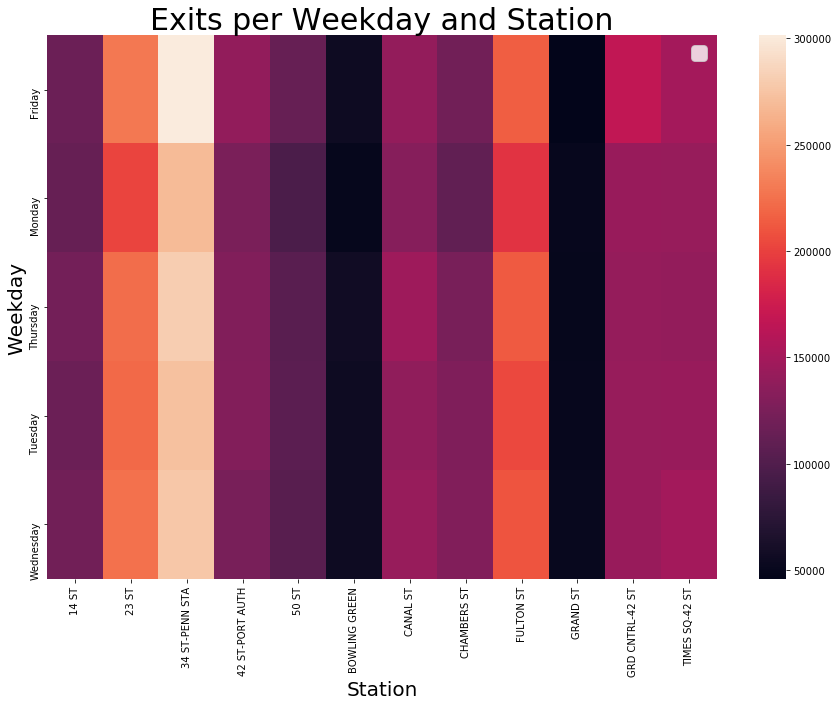

In [186]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.heatmap(heat_df)
plt.title('Exits per Weekday and Station', size=30)
plt.xlabel('Station', size=20)
plt.ylabel('Weekday', size=20)
plt.legend(fontsize=20);
plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/station_heat_map.svg')

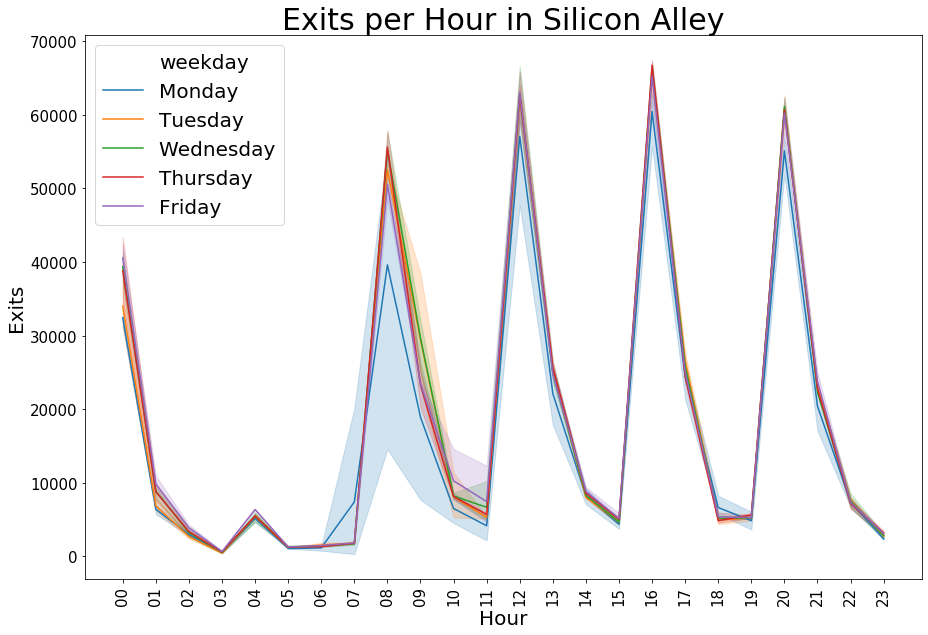

In [187]:
# Graph of time of day
df['hour'] = df['TIME'].astype(str).str[:2]
# list of our targetted stations -- the top Silicon Alley stops
top_silicon_alley_stations = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '14 ST', 'TIMES SQ-42 ST',
                              'BOWLING GREEN', 'FULTON ST', 'GRD CNTRL-42 ST', 'GRAND ST', '34 ST-PENN STA', 'CHAMBERS ST', '50 ST']

# Filter down to just the targetted stations
# then filter out Saturday and Sunday
#data = df[df['STATION'].isin(top_silicon_alley_stations)]
#df = df[~df['weekday'].isin(['Saturday', 'Sunday'])]

# Sort for presentation's sake
data = data[['DATE', 'hour', 'weekday', 'people_out']].groupby(
    ['DATE', 'weekday', 'hour'], as_index=False).sum()
data.sort_values(by=['hour', 'DATE', 'weekday'], inplace=True)
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.lineplot(ax=ax, x='hour', y='people_out', hue='weekday', data=data)
plt.xticks(rotation='vertical', size=15)
plt.yticks(size=15)
plt.title('Exits per Hour in Silicon Alley', size=30)
plt.xlabel('Hour', size=20)
plt.ylabel('Exits', size=20)
plt.legend(fontsize=20)
plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/time_of_day.jpg')